Steady state heat equation
======

This notebook will setup and solve the steady state heat equation. 

The heat equation is given by

\\[
\nabla(k\nabla)T = h
\\]

where $k$ is the conductivity, T the temperature field and $h$ the source term (see [here](https://en.wikipedia.org/wiki/Heat_equation) for more information).

**This tutorial introduces:**
1. Setting up the mesh
2. Creating boundary conditions
3. Solving the heat equation
4. Plotting with glucifer

**Keywords:** initial conditions, boundary conditions, heat equation

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer

Setup parameters
-----

In [2]:
# Set number of dimensions.
dim = 2
# Set box size.
boxHeight = 1.0
boxLength = 2.0
# Set the resolution.
resx = 16
resy = 8

Create mesh and variables
------

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (resx, resy), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))


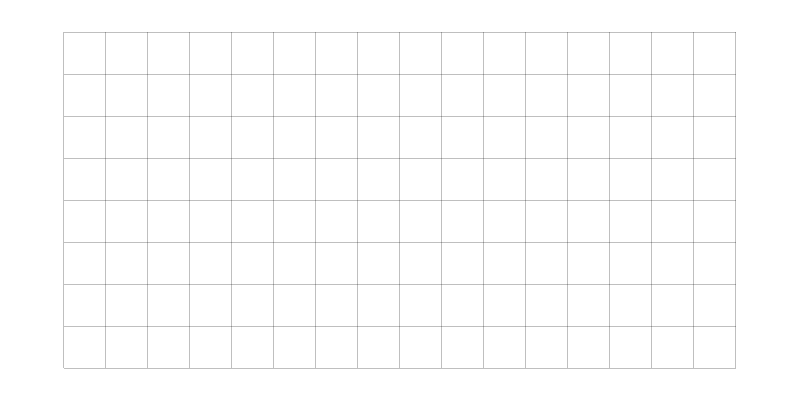

In [4]:
# gLucifer visualisation of mesh
fig = glucifer.Figure( figsize=(800,400) )
fig + glucifer.objects.Mesh( mesh )
fig.show()

Create mesh variables for the temperature field & initialise. 

In [5]:
temperatureField = uw.meshvariable.MeshVariable( mesh=mesh, nodeDofCount=1 )
temperatureField.data[:] = 0.

Create boundary conditions
----------

Determine which vertices will be flagged as boundary conditions on the system using special sets.

In [6]:
mesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'AllWalls_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

The vertices along the bottom wall is given by  'MinJ_VertexSet', the top wall given by the 'MaxJ_VertexSet'.

Construct sets for the horizontal walls.

In [7]:
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Prescribe Direchlet, or fixed value, boundary conditions for the jWalls and provide values.

In [8]:
tempBC = uw.conditions.DirichletCondition( variable=temperatureField, indexSetsPerDof=(jWalls,) )

In [9]:
# set bottom wall temperature bc
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.0
# set top wall temperature bc
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0.0


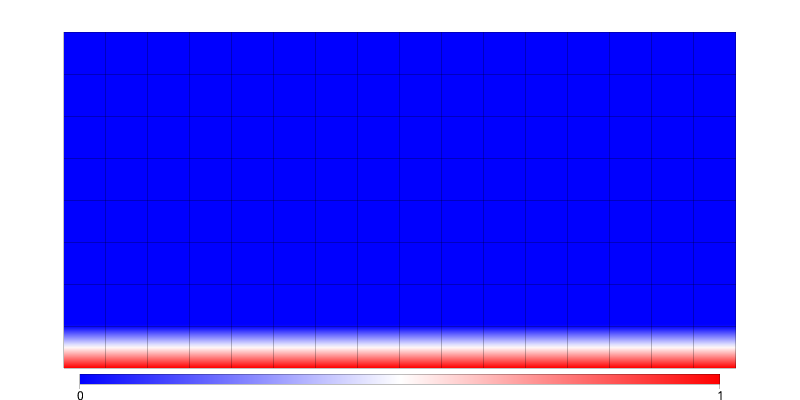

In [10]:
# gLucifer visualisation of temperature field & mesh
fig + glucifer.objects.Surface( mesh, temperatureField, colours="blue white red" )
fig.show()

Heat Equation System setup & solve
-----

Temperature field, conductivity and boundary conditions are passed to the SteadyStateHeat system function.

In [11]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])

Solve the heat equation.

In [12]:
# get the default heat equation solver
heatsolver = uw.systems.Solver(heatequation)
# solve
heatsolver.solve()


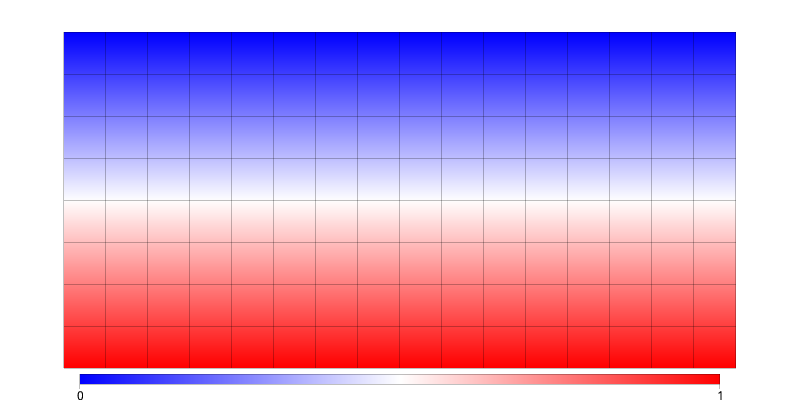

In [13]:
# gLucifer visualisation of temperature field & mesh
fig.show()